# Легенда

Мы работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Нам поставлена задача создать такую модель.

# Загрузка библиотек и данных

In [4]:

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
import plotly.express as px

import category_encoders as ce


from collections import Counter


import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')


from sklearn.model_selection import train_test_split


from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [48]:

RANDOM_SEED = 42

In [5]:
# Подгрузим наши данные из соревнования


df_train = pd.read_csv("D:\coding\project3\hotels_train.csv") # датасет для обучения
df_test = pd.read_csv("D:\coding\project3\hotels_test.csv") # датасет для предсказания
sample_submission = pd.read_csv("D:\coding\project3\submission.csv") # самбмишн

###Первичный анализ данных

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [9]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test, df_train], sort=False).reset_index(drop=True)  # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Создание новых признаков

#### 1. Работа с колонкой 'hotel_address'

In [14]:
# посмотрим, какую информацию содержит в себе колонка 'hotel_address'
list(data['hotel_address'].unique())[:10]

['Via Senigallia 6 20161 Milan Italy',
 'Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands',
 'Mallorca 251 Eixample 08008 Barcelona Spain',
 'Piazza Della Repubblica 17 Central Station 20124 Milan Italy',
 'Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands',
 'Coram Street Camden London WC1N 1HT United Kingdom',
 'Empire Way Wembley Brent London HA9 8DS United Kingdom',
 '1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom',
 '35 Rue Caumartin 9th arr 75009 Paris France',
 '49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom']

In [15]:
# создаём функцию для извлечения города из адреса
def get_city(address):
    address_list = address.split(' ')
    if address_list[-2] == 'United' and address_list[-1] == 'Kingdom':
        return address_list[-5]
    else:
        return address_list[-2]

# создаём функцию для извлечения страны из адреса
def get_country(address):
    address_list = address.split(' ')
    if address_list[-2] == 'United' and address_list[-1] == 'Kingdom':
        return address_list[-2] + ' ' + address_list[-1]
    else:
        return address_list[-1]

# создаём колонки с названиями городов и стран
data['city'] = data['hotel_address'].apply(get_city)
data['country'] = data['hotel_address'].apply(get_country)

# проверяем полученные данные
print('Города:', data['city'].unique())
print('Страны:', data['country'].unique())

Города: ['Milan' 'Amsterdam' 'Barcelona' 'London' 'Paris' 'Vienna']
Страны: ['Italy' 'Netherlands' 'Spain' 'United Kingdom' 'France' 'Austria']


In [16]:
# извлекаем из Википедии информацию о населении и площади имеющихся у нас городов и стран
city_data = pd.DataFrame({
    'city': ['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
    'city_population': [1378689, 872757, 1636732, 8961989, 2148327, 1897491],
    'city_area': [181.67, 219.4, 101.3, 1602, 105.4, 414.75]
})
country_data = pd.DataFrame({
    'country': ['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France', 'Austria'],
    'country_population': [59236213, 17665300, 46552504, 67081000, 68084217, 8923507],
    'country_area': [302073, 41543, 505990, 242495, 643801, 83879]
})

# добавим колонки с плотностью населения
city_data['city_density'] = (city_data['city_population'] / city_data['city_area']).astype('int')
country_data['country_density'] = (country_data['country_population'] / country_data['country_area']).astype('int')

# добавляем полученные данные к датасету с отелями
data = data.join(city_data.set_index('city'), on = 'city')
data = data.join(country_data.set_index('country'), on = 'country')

In [17]:
# создадим дополнительную колонку-индикатор, находится ли отель в столице
capitals = ['Amsterdam', 'London', 'Paris', 'Vienna']
data['is_capital'] = data['city'].apply(lambda x: 1 if x in capitals else 0)

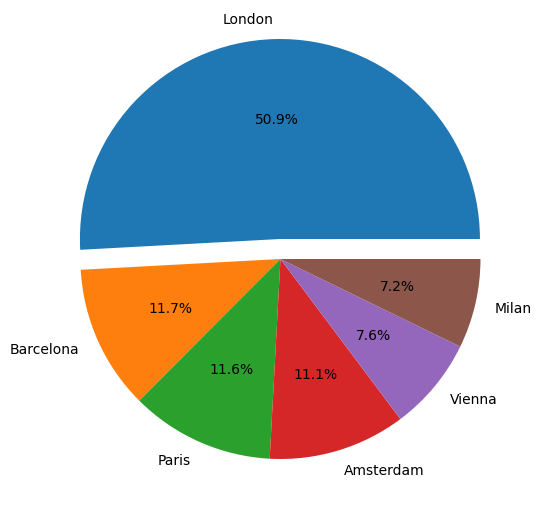

In [18]:
# визуализируем распределение данных по городам
city_data = data['city'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    city_data,
    labels = city_data.index,
    autopct = '%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0]
);

Исходя из круговой диаграммы, показывающей распределение отзывов об отелях по городам можно сделать следующие выводы и инсайты:Лондон: Лондон занимает наибольшую долю отзывов об отелях, составляя 50,9% от общего числа. Это указывает на значительную концентрацию гостиничной активности и, возможно, большое количество туристов, посещающих Лондон.
Барселона: Следующим по численности является Барселона с 11,7%. Это также крупное туристическое направление, известное своей архитектурой и культурой.
Париж: Париж, еще один крупный туристический центр, составляет 11,6% отзывов.
Амстердам: Амстердам отвечает за 11,1% отзывов. 
Вена: Вена имеет 7,6% отзывов, что отражает её статус как исторического и культурного центра Европы.
Милан: Милан имеет наименьшую долю среди перечисленных городов, с 7,2%.

#### 2. Работа с колонкой 'review_date'

In [19]:
# преобразовываем колонку даты в формат datetime
data['review_date'] = pd.to_datetime(data['review_date'])

# извлекаем день недели из даты
data['day_of_week'] = data['review_date'].dt.dayofweek

# извлекаем месяц из даты
data['month'] = data['review_date'].dt.month

In [20]:
# создаём и используем функцию для извлечения сезона
def get_season(date):
    if date.month in [1, 2, 12]:
        return 'winter'
    if date.month in [3, 4, 5]:
        return 'spring'
    if date.month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'
data['season'] = data['review_date'].apply(get_season)

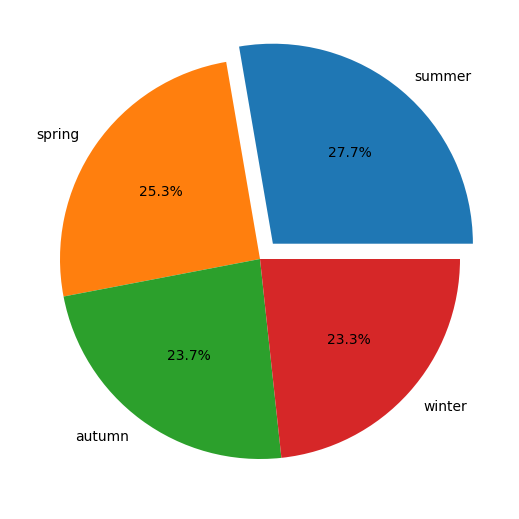

In [21]:
# визуализируем распределение данных по сезонам
season_data = data['season'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    season_data,
    labels = season_data.index,
    autopct = '%.1f%%',
    explode = [0.1, 0, 0, 0]
);


Распределение отзывов по сезонам:Лето (Summer): Сезон с наибольшим количеством отзывов — 27,7%. Это может указывать на высокий туристический поток в летний период, когда погода наиболее благоприятна для путешествий.
Весна (Spring): Второй по популярности сезон для путешествий — весна, с 25,3% отзывов. Это также популярное время для туризма, когда погода становится теплее после зимы.
Осень (Autumn): Осень имеет 23,7% отзывов. Этот сезон также привлекает туристов благодаря мягкой погоде и множеству культурных мероприятий.
Зима (Winter): Зима — сезон с наименьшим количеством отзывов, составляя 23,3%. Это может быть связано с менее благоприятными погодными условиями и меньшим количеством туристических мероприятий.                      
Выводы:

Лето и весна — самые популярные сезоны для путешествий. Это время, когда многие люди берут отпуска, и погода благоприятствует поездкам.
Осень также популярна, хотя и немного уступает весне и лету. Возможно, это связано с тем, что туристы предпочитают избегать больших толп летом и наслаждаться более спокойным отдыхом.
Зима — наименее популярный сезон для путешествий. Это может быть связано с холодной погодой и меньшим количеством мероприятий.
Планирование туристических услуг:

Туристические компании и отели могут использовать эту информацию для планирования своих услуг и маркетинговых стратегий. Например, они могут предлагать специальные зимние предложения, чтобы привлечь больше туристов в этот период.
Летний и весенний периоды требуют большей готовности и ресурсов для обслуживания увеличенного потока туристов.
Анализ данных по сезонам:


#### 3. Работа с колонкой 'hotel_name'

In [22]:
# поищем найболее полезные слова в названиях отелей
words = []
for hotel in data['hotel_name'].values:
    words.extend(hotel.split(' '))

# создаём объект Counter и передаём в него полученные слова для подсчёта
word_counts = Counter(words)

# с помощью метода most_common() наблюдаю найболее популярные слова
word_counts.most_common()[:10]

[('Hotel', 234378),
 ('London', 137227),
 ('The', 58053),
 ('Park', 43929),
 ('Amsterdam', 39868),
 ('Hilton', 35490),
 ('by', 24369),
 ('Plaza', 23105),
 ('Paris', 21792),
 ('Grand', 18430)]

In [23]:
# выберем 15 слов, которые на мой взгляд могут на что-то влиять
words_to_apply = [
    'park', 'hilton', 'plaza', 'grand', 'inn', 'city', 'holiday', 'western',
    'palace', 'radisson', 'blu', 'mercure', 'tower', 'paddington', 'novotel'
]

# перебираем выбранные слова и создаём колонки-индикаторы, указывающие, содеражат ли отели эти слова в названии
for word in words_to_apply:
    data[word + '_hotel'] = data['hotel_name'].apply(
        lambda x: 1 if word in x.lower() else 0
    )

#### 4. Работа с колонкой 'reviewer_nationality'

In [24]:
# для начала очистим значения от лишних пробелов
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

# отмечаем является ли рецензент гражданином страны, в которой находится отель
data['is_citizen'] = data['reviewer_nationality'] == data['country']
data['is_citizen'] = data['is_citizen'].astype('int')

# оставим в списке только 15 самых популярных национальностей, остальные заполним значением 'other'
top_nations = list(data['reviewer_nationality'].value_counts()[:15].index)
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_nations else 'other')

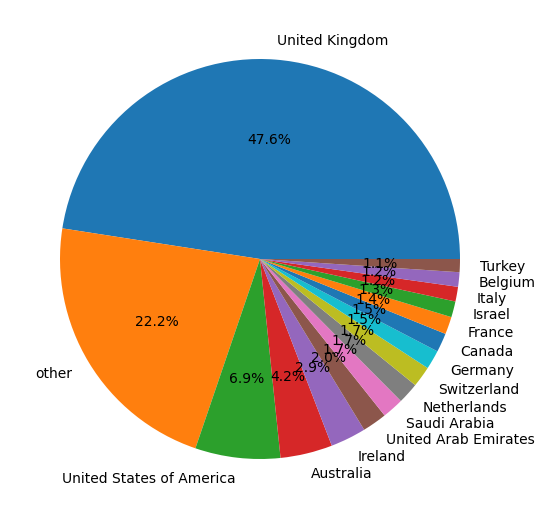

In [25]:
# визуализируем распределение данных по гражданству
reviewer_data = data['reviewer_nationality'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    reviewer_data,
    labels = reviewer_data.index,
    autopct = '%.1f%%'
);

Распределение отзывов по национальностям рецензентов:
Великобритания (United Kingdom): Наибольшая доля отзывов приходится на рецензентов из Великобритании — 47,6%. Это может быть связано с тем, что Лондон (являющийся одним из анализируемых городов) находится в Великобритании и привлекает большое количество местных туристов.
Прочие страны (Other): На втором месте по количеству отзывов — категория "прочие", которая составляет 22,2%. Это включает рецензентов из других стран, не вошедших в топ-15.
Соединенные Штаты Америки (United States of America): Рецензенты из США составляют 6,9% от общего числа отзывов. Это указывает на значительное количество туристов из США.
Австралия (Australia): Доля рецензентов из Австралии составляет 4,2%.
Ирландия (Ireland): 2,9% отзывов оставлены рецензентами из Ирландии.
Объединенные Арабские Эмираты (United Arab Emirates), Саудовская Аравия (Saudi Arabia), Нидерланды (Netherlands), Швейцария (Switzerland), Германия (Germany), Канада (Canada), Франция (France), Израиль (Israel), Италия (Italy), Бельгия (Belgium) и Турция (Turkey): Эти страны составляют оставшуюся часть отзывов, каждая с долей от 1,0% до 1,7%.
Выводы:
Доминантная роль Великобритании: Почти половина всех отзывов оставлена рецензентами из Великобритании. Это может быть объяснено тем, что Лондон — популярное туристическое направление, как для внутренних, так и для международных туристов.
Многонациональность туристов: Категория "прочие" занимает значительную долю, что указывает на разнообразие национальностей туристов, посещающих анализируемые города.
Значительное присутствие туристов из США и Австралии: Туристы из США и Австралии составляют значительную часть рецензентов, что может указывать на популярность европейских городов среди этих наций.
Низкая доля граждан стран, в которых находятся отели: Из оставшихся 10 стран, каждая имеет относительно небольшую долю, что может указывать на меньшую активность туристов из этих стран или их меньшую численность по сравнению с туристами из других стран.

#### 5. Работа с колонками 'negative_review' и 'positive_review'

In [26]:
# посмотрим на самые популярные отзывы
display(data['negative_review'].value_counts()[:10])
print() # отступ
display(data['positive_review'].value_counts()[:10])

negative_review
No Negative    127890
 Nothing        14295
 Nothing         4236
 nothing         2225
 N A             1037
 None             984
                  849
 N a              509
 Breakfast        407
 Small room       373
Name: count, dtype: int64

positive_review
No Positive        35946
 Location           9222
 Everything         2284
 location           1677
 Nothing            1243
 The location       1126
 Great location     1047
 Good location       927
 Location            915
 Everything          613
Name: count, dtype: int64

Для выражения негативных и позитивных отзывов в числовом формате будем использовать класс SentimentIntensityAnalyzer из библиотеки nltk. Для его коректной работы необходимы некоторые преобразования в значениях нашего датасета.

In [27]:
# уберём лишние пробелы и приведём все символы к нижнему регистру
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.strip().lower()
)
data['positive_review'] = data['positive_review'].apply(
    lambda x: x.strip().lower()
)

# отсутствие отзывов дающее эмоциональную окраску заполняем пустыми строками
not_negative = [
    'no negative', 'no complaints', 'nothing all good', 'having to leave',
    'nothing it was perfect', 'nothing everything was perfect',
    'there was nothing i didn t like', 'no'
]
not_positive = ['no positive']

data['negative_review'] = data['negative_review'].apply(
    lambda x: '' if x in not_negative else x
)
data['positive_review'] = data['positive_review'].apply(
    lambda x: '' if x in not_positive else x
)

# популярные значения, имеющие эмоциональную окраску в зависимости от того, в какой  колонке они находятся, дополним суффиксом в соответствии с названием колонки

real = [
    'location', 'the location', 'everything', 'small room', 'breakfast',
    'price', 'small rooms', 'staff', 'location and staff', 'location staff',
    'location location location', 'comfy bed', 'expensive', 'room size',
    'expensive breakfast', 'the price', 'the staff', 'all', 'every thing',
    'cleanliness', 'location breakfast', 'location only', 'wifi', 'pillows',
    'parking', 'size of room', 'the breakfast', 'breakfast too expensive',
    'central location', 'staff and location', 'the bed', 'convenient location',
    'position', 'location and breakfast'
]

data['positive_review'] = data['positive_review'].apply(
    lambda x: x + ' positive' if x in real else x
)
data['negative_review'] = data['negative_review'].apply(
    lambda x: x + ' negative' if x in real else x
)

In [28]:
# создаём класс SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

# создаём колонки с числовым выражением отзывов
data['negative_neg'] = data['negative_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['neg']
)
data['negative_neu'] = data['negative_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['neu']
)
data['negative_pos'] = data['negative_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['pos']
)
data['negative_compound'] = data['negative_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['compound']
)
data['positive_neg'] = data['positive_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['neg']
)
data['positive_neu'] = data['positive_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['neu']
)
data['positive_pos'] = data['positive_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['pos']
)
data['positive_compound'] = data['positive_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['compound']
)

#### 6. Работа с колонкой 'tags'

In [29]:
# создаём полный список тэгов
tags = []
for tag_list in data['tags'].values:
    tag_list = tag_list.replace("[' ", "")
    tag_list = tag_list.replace(" ']", "")
    tag_list = tag_list.split(" ', ' ")
    tags.extend(tag_list)

# подсчитываем количество тэгов с помощью класса Counter
tag_counter = Counter(tags)
sorted_tags = list(tag_counter.most_common())
sorted_tags[:10]

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015)]

In [30]:
# создаём функцию и извлекаем количество ночей, проведённых в отеле
def get_stayed_nights(tags):
    tags_list = tags.split(' ')
    if 'Stayed' in tags_list:
        night_index = tags_list.index('Stayed') + 1
        return int(tags_list[night_index])
    else:
        return np.NaN

data['stayed_nights'] = data['tags'].apply(get_stayed_nights)


# дополним датасет ещё 15 колонками-индикаторами самых популярных тэгов
new_columns = []

for tag, count in sorted_tags:
    if 'Stayed' not in tag:
        new_columns.append(tag)    
        
for column in new_columns[:15]:
    data[column] = data['tags'].apply(lambda x: 1 if column in x else 0)

#### 7. Работа с колонкой 'days_since_review'

In [31]:
# разбиваем колонку по пробелу и оставляем только числовую часть данных
data['days_since_review'] = data['days_since_review'].apply(
    lambda x: int(x.split(' ')[0])
)

#### 8. Кодирование признаков

In [32]:
# Номинальные признаки содержащие не более 16 уникальных значений, кодируем используя класс OneHotEncoding.
encoder = ce.OneHotEncoder(
    cols = ['city', 'day_of_week', 'month', 'season', 'reviewer_nationality']
)
data_bin = encoder.fit_transform(
    data[['city', 'day_of_week', 'month', 'season', 'reviewer_nationality']]
)
data = pd.concat([data, data_bin], axis = 1)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\ordinal.py:198: FutureWa

# Очистка от пропущенных значений

In [33]:
# заполним пропуски в географических координатах модальным значением в зависимости от города
data['lat'] = data['lat'].fillna(
    data.groupby(['city'])['lat'].transform(lambda x: x.mode()[0])
)
data['lng'] = data['lng'].fillna(
    data.groupby(['city'])['lng'].transform(lambda x: x.mode()[0])
)

# пропущенные значения в колонке 'stayed_nights' заполняем модальным значением
data['stayed_nights'].fillna(data['stayed_nights'].mode()[0], inplace=True)
# и заменяем тип данных на 'int'
data['stayed_nights'] = data['stayed_nights'].astype('int')

C:\Users\USER\AppData\Local\Temp\ipykernel_20512\2352229920.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['stayed_nights'].fillna(data['stayed_nights'].mode()[0], inplace=True)


# Удаление строковых значений

In [34]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace = True)

# удаляем колонку с типом datetime
data.drop('review_date', axis = 1, inplace = True)

# удаляем колонки 'day_of_week' и 'month', которые уже закодированы как категориальные
data = data.drop(['day_of_week', 'month'], axis = 1)

# Преобразование признаков

Так как у нас получилось очень много бинарных признаков (со значением 0 или 1), то и остальные признаки будет логичным привести к этому диапозону.

In [35]:
# сохраняем колонки которые будем преобразовывать
col_names = []
for col in data.columns:
    if (data[col].min() < 0 or data[col].max() > 1) and col != 'reviewer_score':
        col_names.append(col)

# выводим полученный результат
print('Колонки к преобразованию:')
for col in col_names:
    print(col)

Колонки к преобразованию:
additional_number_of_scoring
average_score
review_total_negative_word_counts
total_number_of_reviews
review_total_positive_word_counts
total_number_of_reviews_reviewer_has_given
days_since_review
lat
lng
city_population
city_area
city_density
country_population
country_area
country_density
negative_compound
positive_compound
stayed_nights


In [36]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# создаём нормализованные колонки
data_mm = mm_scaler.fit_transform(data[col_names])

# преобразуем промежуточный датасет в полноценный датафрейм
data_mm = pd.DataFrame(data_mm, columns = col_names)

# удаляем преобразованные колонки из исходного датасета
data = data.drop(col_names, axis = 1)

# объеденяем данные
data = pd.concat([data_mm, data], axis = 1)

# Отбор признаков

#### 1. Анализ мультиколлинеарности

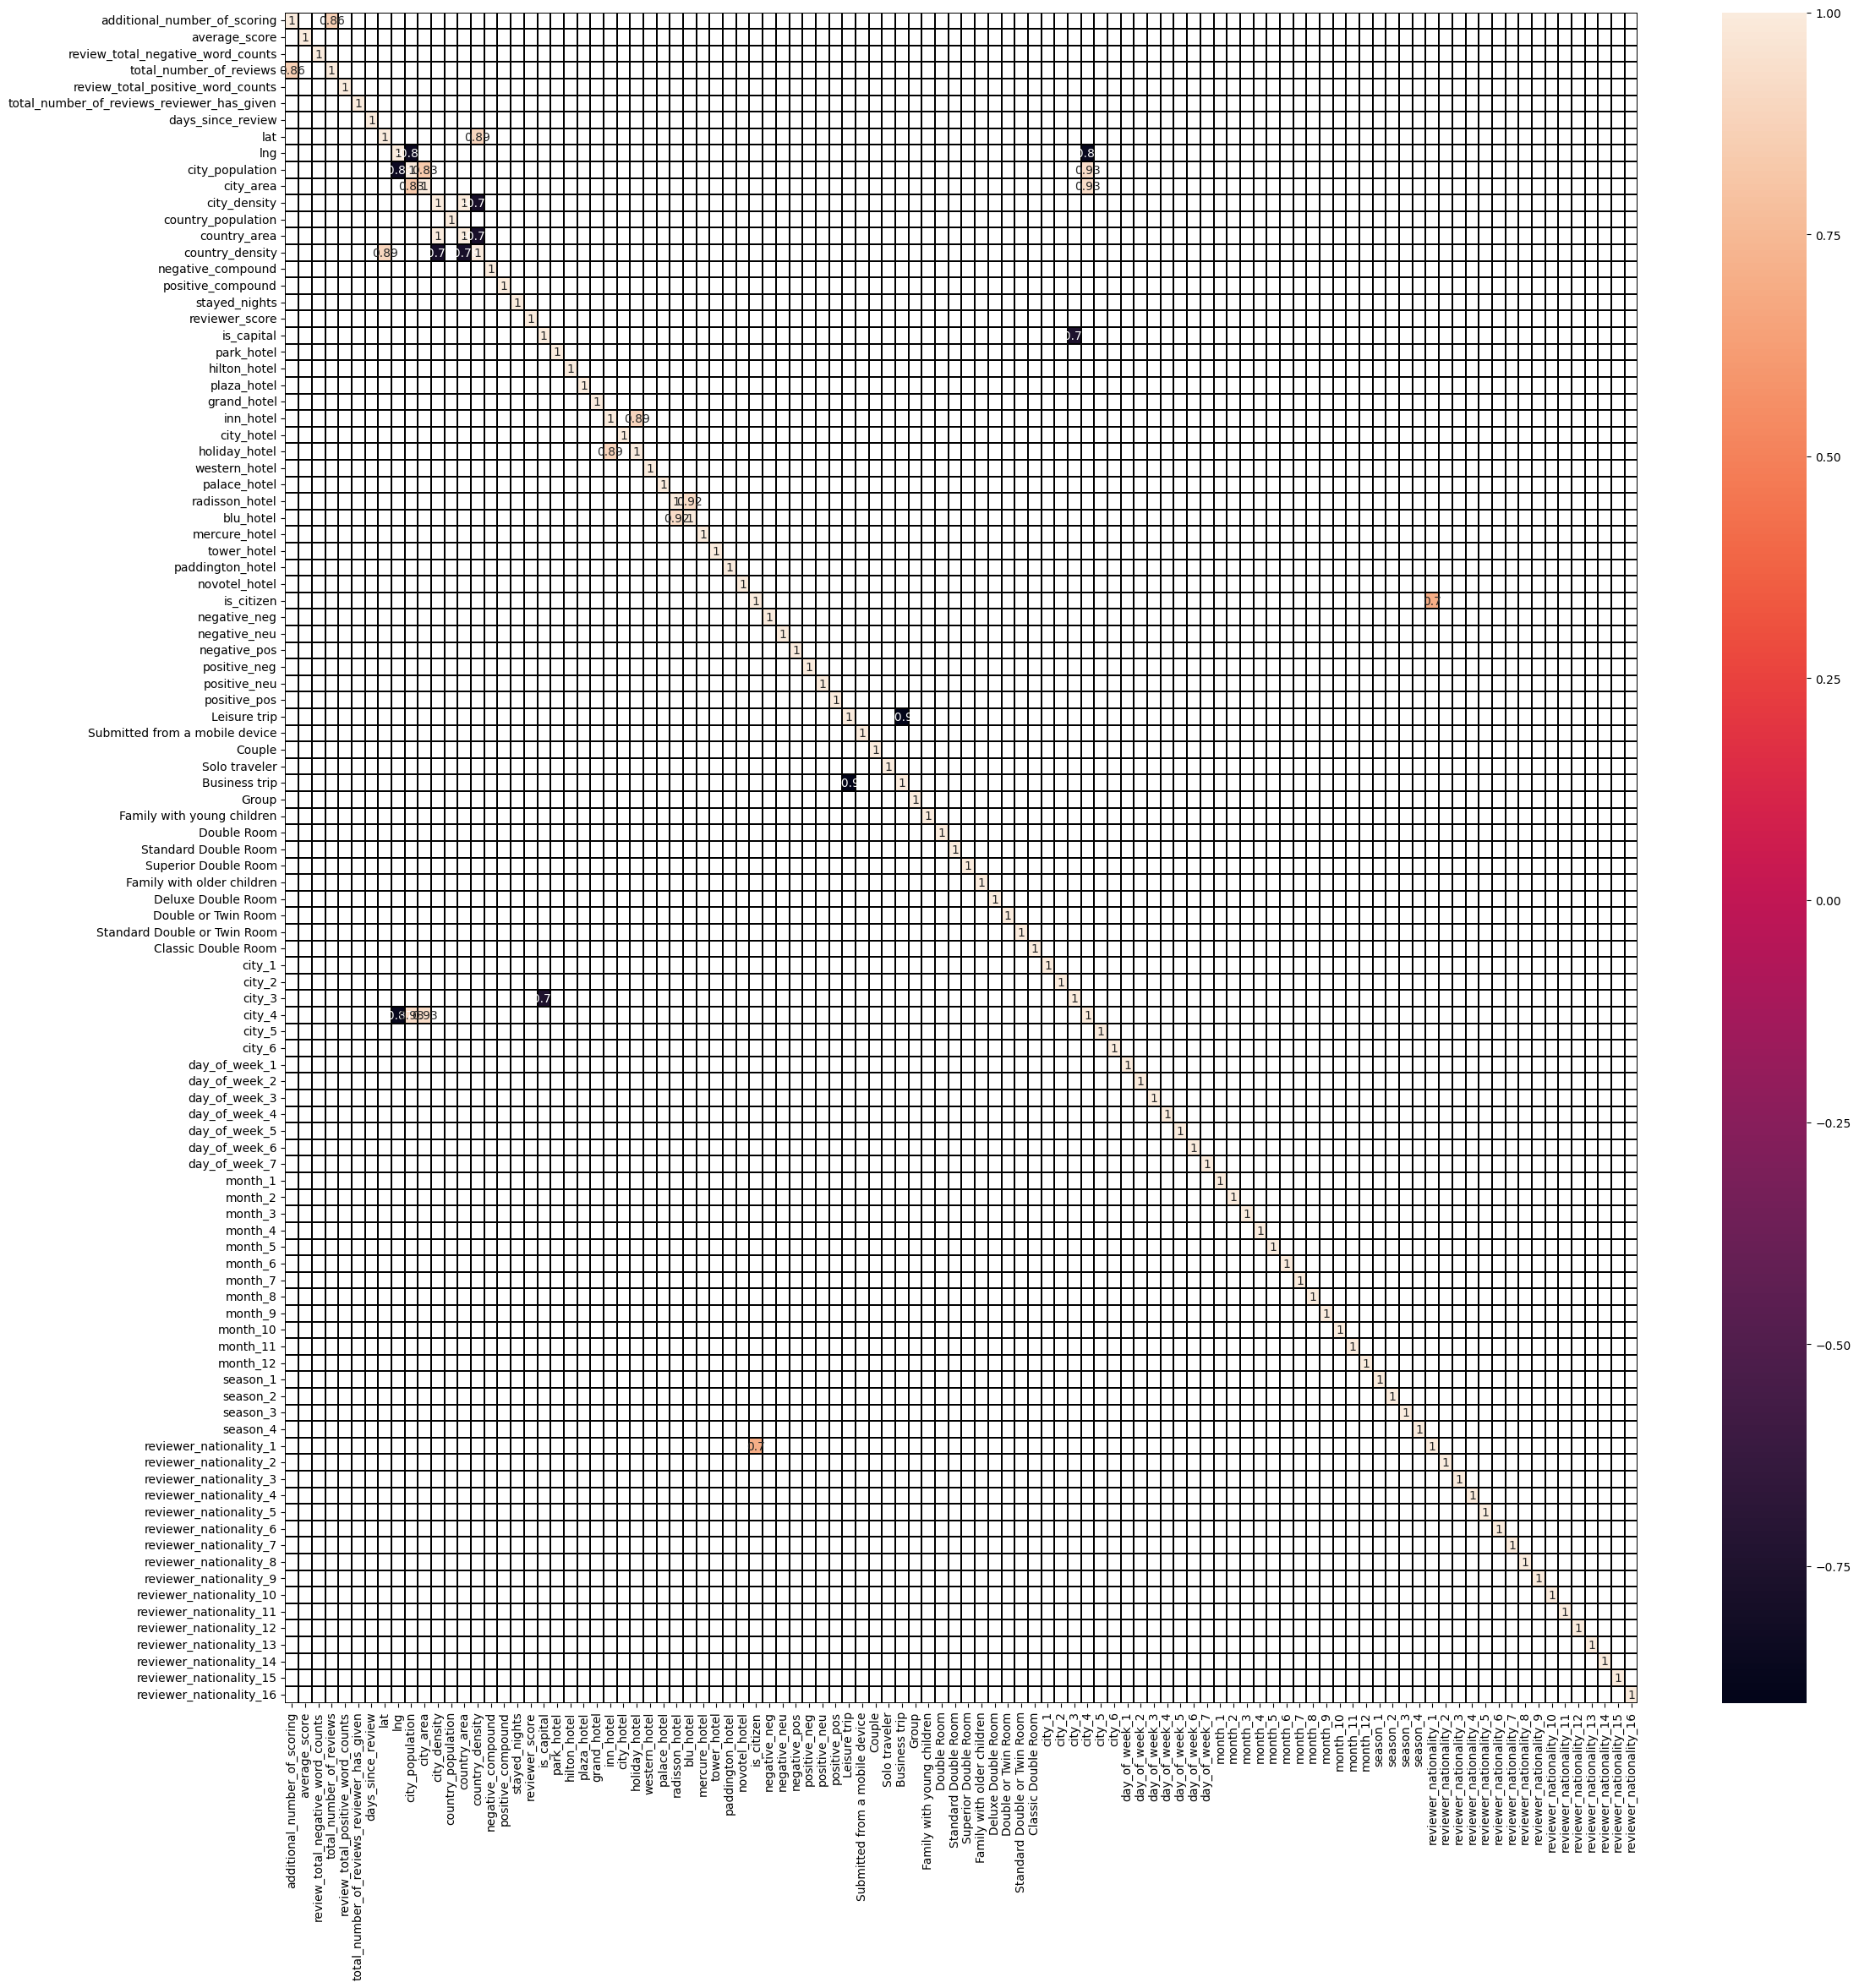

In [37]:
# для корреляции с категориальными признаками будем использовать метод Спирмена
corr = data.drop(['sample'], axis=1).corr(method = 'spearman')

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.70
mask_2 = np.abs(corr) <= -0.70
corr_data = corr[mask_1 | mask_2]

fig = plt.figure(figsize=(20, 20))
axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr_data, annot=True, ax=axes, linewidth=0.3, linecolor='black');

На основании представленной корреляционной матрицы методом Спирмена, можно сделать следующие выводы:

Признаки с высокой положительной корреляцией:
Видим, что некоторые признаки имеют высокую положительную корреляцию (значения близкие к 1). Например, это могут быть столбцы, связанные с числом отзывов, например, total_number_of_reviews и additional_number_of_scoring.
Признаки с высокой отрицательной корреляцией:
Отрицательная корреляция (значения близкие к -1) менее очевидна, но может присутствовать в данных, отражающих противоположные тенденции, такие как "позитивный отзыв" и "негативный отзыв".
Группировки по корреляции:

Высокая корреляция между признаками может указывать на их избыточность. Например, если два признака сильно коррелируют, возможно, один из них можно исключить без потери информации для модели.
Признаки, связанные с временными аспектами (месяц, день недели), могут показывать корреляцию с сезонностью отзывов и активностью в определенные периоды.

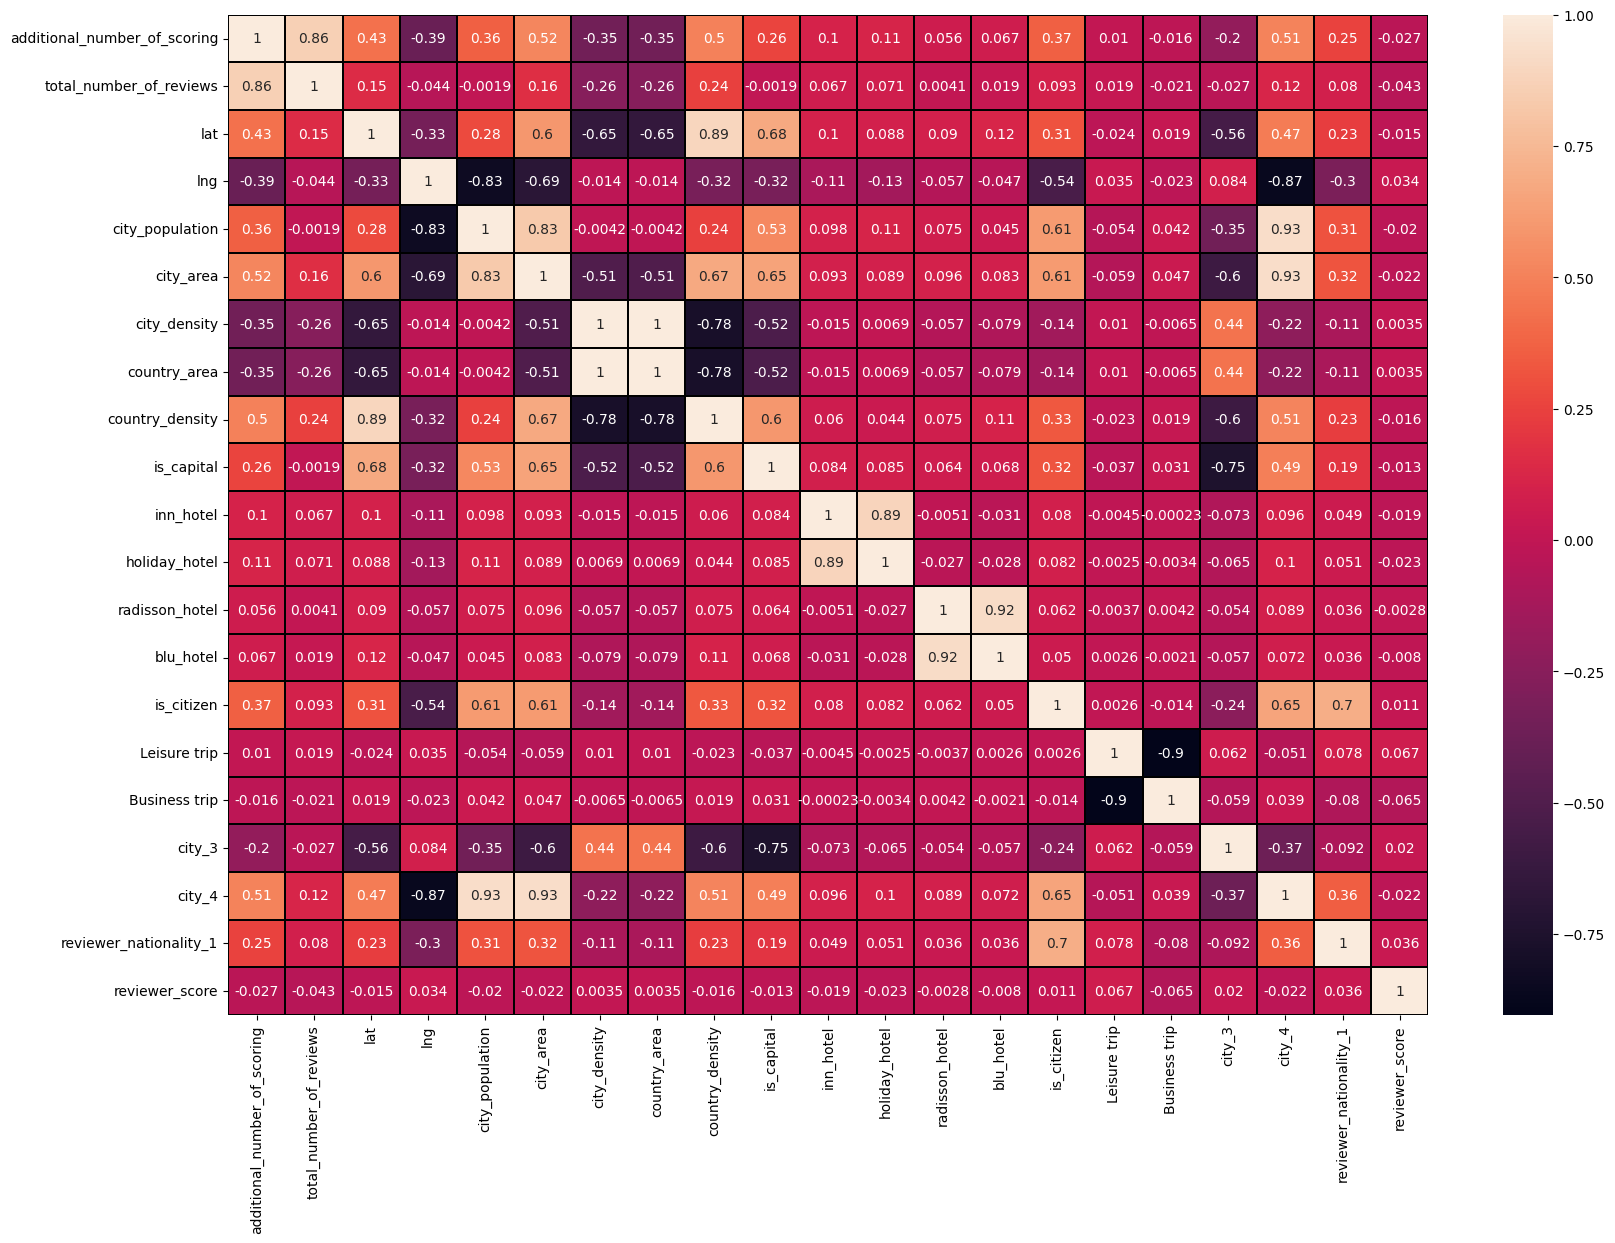

In [38]:
# чтобы понять какие признаки удалить, посмотрим как они коррелируют с целевым признаком 'reviewer_score'
corr = data[[
    'additional_number_of_scoring', 'total_number_of_reviews', 'lat', 'lng',
    'city_population', 'city_area', 'city_density', 'country_area',
    'country_density', 'is_capital', 'inn_hotel', 'holiday_hotel',
    'radisson_hotel', 'blu_hotel', 'is_citizen', 'Leisure trip',
    'Business trip', 'city_3', 'city_4', 'reviewer_nationality_1',
    'reviewer_score'
]].corr(method = 'spearman')

fig = plt.figure(figsize=(15, 10))
axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, ax=axes, linewidth=0.3, linecolor='black');

можно сделать следующие выводы:

Корреляция признаков с целевым признаком:
reviewer_score:
Слабая отрицательная корреляция с такими признаками, как total_number_of_reviews (-0.043) и lat (-0.015).
Слабая положительная корреляция с признаками city_4 (0.036), Leisure trip (0.078), и reviewer_nationality_1 (0.036).
Значимые корреляции между признаками:

Высокая положительная корреляция наблюдается между:
additional_number_of_scoring и total_number_of_reviews (0.86).
city_density и city_population (0.61), country_density (0.61).
blu_hotel и radisson_hotel (0.92).
Высокая отрицательная корреляция наблюдается между:
lng и lat (-0.83).
city_area и city_density (-0.69).
country_area и country_density (-0.78).
Выводы и рекомендации:
Избыточность признаков:

Признаки additional_number_of_scoring и total_number_of_reviews сильно коррелируют между собой (0.86). Можно оставить один из них, чтобы уменьшить избыточность данных.
Признаки blu_hotel и radisson_hotel также имеют высокую корреляцию (0.92). Рассмотрите возможность объединения или исключения одного из них.
Пары признаков, такие как lng и lat, имеют высокую отрицательную корреляцию (-0.83). Это указывает на сильную взаимосвязь, что может потребовать анализа при построении модели.
Признаки с низкой корреляцией с целевым признаком:

Признаки, такие как total_number_of_reviews, lat, lng, is_capital, inn_hotel, и is_citizen, имеют слабую корреляцию с целевым признаком reviewer_score. Эти признаки могут быть менее информативными для модели и могут быть рассмотрены для исключения.




In [39]:
# удаляем те признаки, которые меньше коррелируют с целевым признаком
data = data.drop([
    'radisson_hotel', 'city_density', 'country_area', 'is_citizen',
    'is_capital', 'lat', 'inn_hotel', 'city_population', 'city_4',
    'additional_number_of_scoring', 'Business trip'
], axis = 1)

#### 2. Оценка значимости признаков

In [40]:
# разбиваем датафрейм на части, необходимые для оценки значимости
# X - данные с информацией об отелях, y - целевая переменная (рейтинги отелей)
X = data.drop(['reviewer_score'], axis = 1)
y = data['reviewer_score'].astype('int')


# разделяем признаки на непрерывные и категориальные
num_cols = [
    'average_score', 'review_total_negative_word_counts',
    'total_number_of_reviews', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'days_since_review',
    'city_area', 'country_population', 'country_density', 'negative_compound',
    'positive_compound', 'stayed_nights', 'negative_neg', 'negative_neu',
    'negative_pos', 'positive_neg', 'positive_neu', 'positive_pos'
]
cat_cols = [
    'lng', 'park_hotel', 'hilton_hotel', 'plaza_hotel',
    'grand_hotel', 'city_hotel', 'holiday_hotel', 'western_hotel',
    'palace_hotel', 'blu_hotel', 'mercure_hotel',
    'tower_hotel', 'paddington_hotel', 'novotel_hotel',
    'Leisure trip', 'Submitted from a mobile device', 'Couple',
    'Solo traveler', 'Group', 'Family with young children',
    'Double Room', 'Standard Double Room', 'Superior Double Room',
    'Family with older children', 'Deluxe Double Room', 'Double or Twin Room',
    'Standard Double or Twin Room', 'Classic Double Room', 'city_1', 'city_2',
    'city_3', 'city_5', 'city_6', 'day_of_week_1', 'day_of_week_2',
    'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
    'day_of_week_7', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
    'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
    'month_12', 'season_1', 'season_2', 'season_3', 'season_4',
    'reviewer_nationality_1', 'reviewer_nationality_2',
    'reviewer_nationality_3', 'reviewer_nationality_4',
    'reviewer_nationality_5', 'reviewer_nationality_6',
    'reviewer_nationality_7', 'reviewer_nationality_8',
    'reviewer_nationality_9', 'reviewer_nationality_10',
    'reviewer_nationality_11', 'reviewer_nationality_12',
    'reviewer_nationality_13', 'reviewer_nationality_14',
    'reviewer_nationality_15', 'reviewer_nationality_16'
]

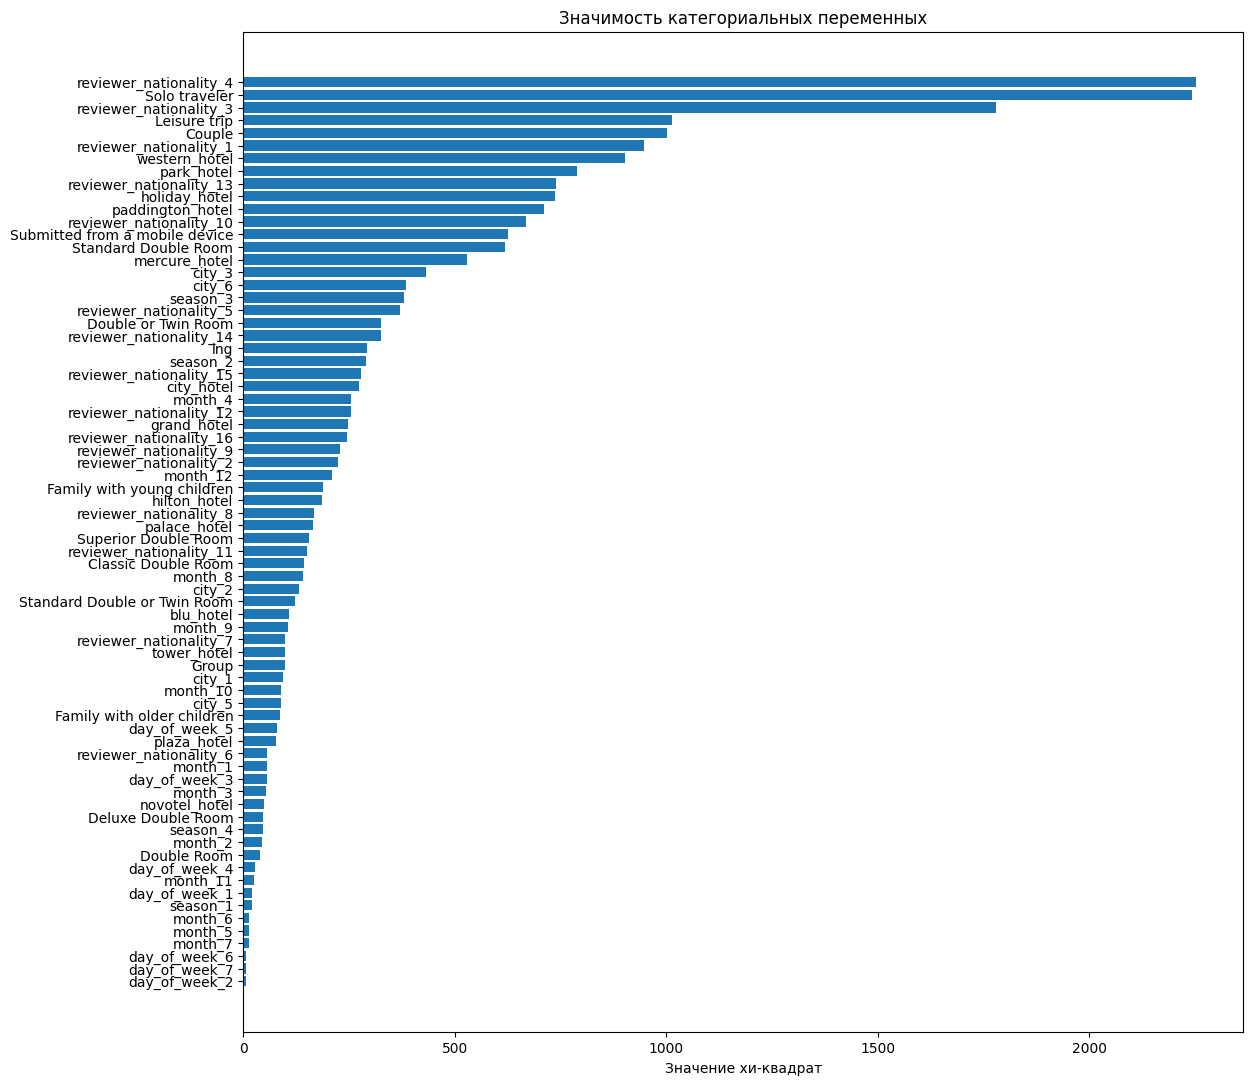

In [41]:
# для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index = cat_cols)
imp_cat.sort_values(inplace = True)

# визуализируем полученные результаты
fig = plt.figure(figsize=(10, 10))
axes = fig.add_axes([0, 0, 1, 1])
axes.barh(imp_cat.index, imp_cat)
axes.set_title('Значимость категориальных переменных')
axes.set_xlabel('Значение хи-квадрат');

можно сделать следующие выводы:

Наиболее значимые переменные:
reviewer_nationality_4, Solo traveler, reviewer_nationality_3: Эти переменные имеют наибольшее значение хи-квадрат, что указывает на их значительное влияние на целевой признак reviewer_score.
Leisure trip, Couple: Тип поездки также играет важную роль, что свидетельствует о том, что отзывы могут сильно зависеть от типа поездки.
Western Hotel, Park Hotel, Holiday Hotel: Эти конкретные отели имеют значительное влияние, что может указывать на их высокую популярность или особые характеристики, которые привлекают отзывы.

Средняя значимость:
city_6, season_3: Эти переменные показывают среднюю значимость, что указывает на некоторую степень влияния, но не такую сильную, как у наиболее значимых переменных.
Standard Double Room, Submitted from a mobile device: Тип номера и способ отправки отзыва также оказывают влияние, хотя и в меньшей степени.

Менее значимые переменные:
day_of_week_2, month_6, season_5: Эти переменные имеют наименьшее значение хи-квадрат, что указывает на их незначительное влияние на целевой признак.
Deluxe Double Room, Group, Family with older children: Эти переменные имеют низкую значимость, что может указывать на слабую связь с оценками отзывов.

In [42]:
# оставим только найболее значимую половину категориальных признаков
cols_to_drop = imp_cat[imp_cat.values < imp_cat.median()]
data = data.drop(cols_to_drop.index, axis = 1)

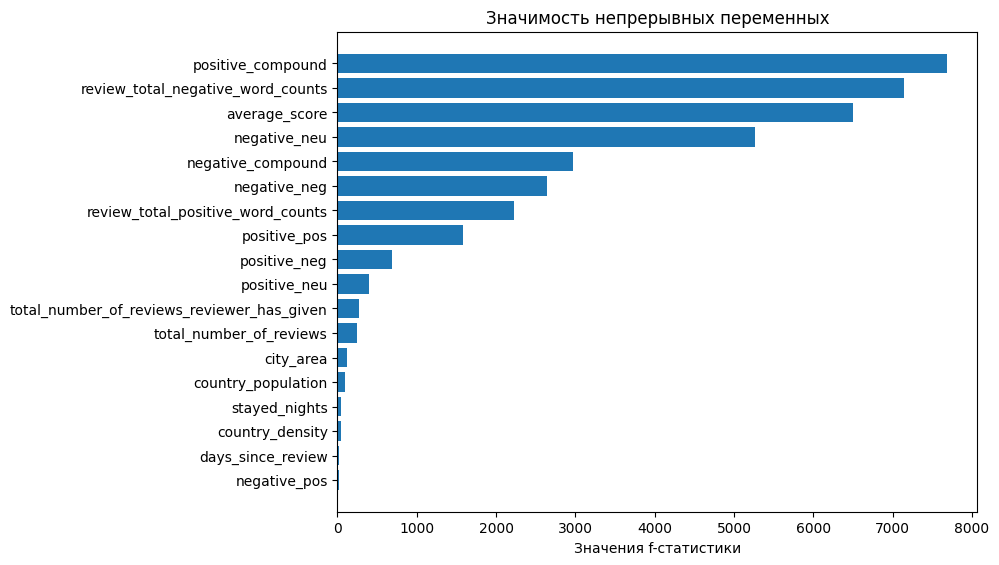

In [43]:
# для оценки значимости непрерывных переменных будем использовать функцию f_classif
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

# визуализируем полученные результаты
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.barh(imp_num.index, imp_num)
axes.set_title('Значимость непрерывных переменных')
axes.set_xlabel('Значения f-cтатистики');

можно сделать следующие выводы:

Наиболее значимые переменные:
positive_compound: Суммарная положительная оценка имеет наибольшее значение f-статистики, что указывает на её значительное влияние на целевой признак reviewer_score.
review_total_negative_word_counts: Количество слов в отрицательных отзывах также является важным показателем, оказывающим значительное влияние.
average_score: Средняя оценка также имеет высокую значимость, что свидетельствует о её важности при формировании общего впечатления.

Значимые переменные:
negative_neu, negative_compound, negative_neg: Переменные, связанные с отрицательными отзывами, такие как нейтральные и составные оценки, также имеют значительное влияние.
review_total_positive_word_counts, positive_pos: Количество слов в положительных отзывах и положительные оценки также важны.

Менее значимые переменные:
total_number_of_reviews_reviewer_has_given, total_number_of_reviews: Эти переменные имеют меньшую значимость, но все еще оказывают влияние.
city_area, country_population: Площадь города и население страны имеют наименьшую значимость среди представленных переменных.

In [44]:
# оставим только найболее значимую половину числовых признаков
cols_to_drop = imp_num[imp_num.values < imp_num.median()]
data = data.drop(cols_to_drop.index, axis = 1)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 47 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   average_score                      515738 non-null  float64
 1   review_total_negative_word_counts  515738 non-null  float64
 2   review_total_positive_word_counts  515738 non-null  float64
 3   lng                                515738 non-null  float64
 4   negative_compound                  515738 non-null  float64
 5   positive_compound                  515738 non-null  float64
 6   sample                             515738 non-null  int64  
 7   reviewer_score                     515738 non-null  float64
 8   park_hotel                         515738 non-null  int64  
 9   hilton_hotel                       515738 non-null  int64  
 10  grand_hotel                        515738 non-null  int64  
 11  city_hotel                         5157

# Этап машинного обучения

In [46]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [49]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [50]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 46), (386803, 46), (386803, 45), (309442, 45), (77361, 45))

In [51]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [52]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [53]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished


In [54]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8754505335816914


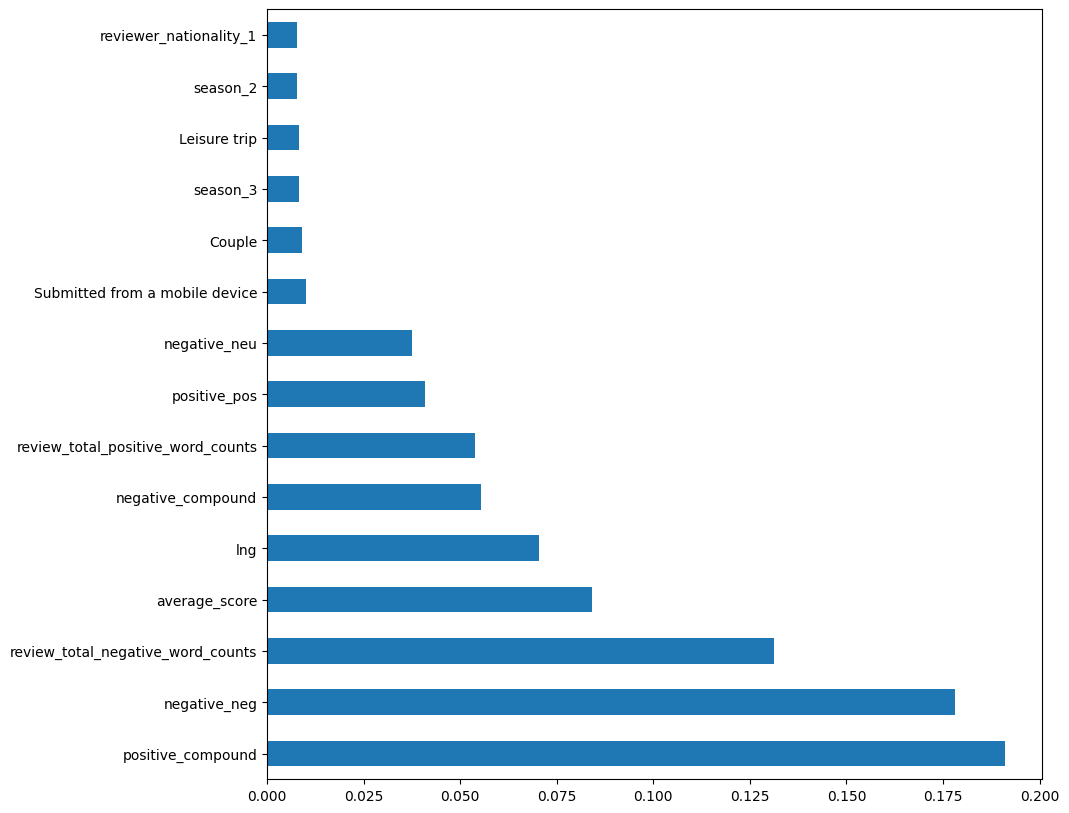

In [55]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

можно сделать следующие выводы:

Наиболее важные признаки:
positive_compound: Суммарная положительная оценка имеет наибольшую важность, что указывает на ее значительное влияние на целевой признак reviewer_score.
negative_neg: Отрицательные оценки также играют важную роль, что подтверждает важность анализа негативных отзывов.
review_total_negative_word_counts: Количество слов в отрицательных отзывах оказывает значительное влияние на оценки, что может указывать на то, что длинные негативные отзывы более детализированы и влияют на общее впечатление.

Значимые признаки:
average_score: Средняя оценка отеля также является важным признаком, что ожидаемо, так как она непосредственно отражает общее впечатление от отеля.
lng: Географическая долгота отеля имеет некоторое влияние, что может указывать на региональные особенности.
negative_compound, review_total_positive_word_counts: Суммарные негативные и позитивные оценки также имеют значительную важность, что подчеркивает важность анализа всех аспектов отзывов.

Менее значимые, но все еще важные признаки:
positive_pos, negative_neu: Эти признаки, связанные с позитивными и нейтральными аспектами отзывов, также важны, хотя и в меньшей степени.
Submitted from a mobile device: Указание на то, что отзыв был отправлен с мобильного устройства, оказывает некоторое влияние, что может быть связано с различиями в поведении пользователей мобильных и десктопных устройств.
Couple, Leisure trip: Тип поездки (например, пара или отдых) также важен, что указывает на различия в восприятии отелей разными категориями путешественников.

In [56]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,lng,negative_compound,positive_compound,reviewer_score,park_hotel,hilton_hotel,grand_hotel,...,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_8,reviewer_nationality_9,reviewer_nationality_10,reviewer_nationality_12,reviewer_nationality_13,reviewer_nationality_14,reviewer_nationality_15,reviewer_nationality_16
66418,0.543478,0.247549,0.078481,0.011242,0.561967,0.948900,0.0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
78961,0.478261,0.000000,0.007595,0.009720,0.500451,0.495964,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5591,0.826087,0.022059,0.035443,0.151443,0.228567,0.956820,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106792,0.782609,0.004902,0.005063,0.569865,0.500451,0.777139,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89218,0.804348,0.007353,0.020253,0.570097,0.500451,0.495964,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119338,0.891304,0.000000,0.053165,0.014528,0.500451,0.718119,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118620,0.608696,0.029412,0.037975,0.014560,0.721247,0.937147,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41241,0.739130,0.034314,0.055696,0.149473,0.175273,0.495964,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16568,0.760870,0.063725,0.040506,0.570076,0.239296,0.874092,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83270,0.630435,0.036765,0.000000,0.011296,0.500451,0.495964,0.0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [57]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [58]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [59]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.0s finished


In [60]:
predict_submission

array([8.717, 7.908, 8.209, ..., 8.078, 9.549, 7.322])

In [61]:
list(sample_submission)

['reviewer_score', 'id']

In [62]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.717,488440
1,7.908,274649
2,8.209,374688
3,9.716,404352
4,9.677,451596
5,8.709,302161
6,7.444,317079
7,7.723,13963
8,8.291,159785
9,7.370,195089
